# Trend

Trend is defined as the direction of growth over a period of time.  There can be be upwards, downwards, and flat trends. Many times, trend is obvious by looking at a simple plot of data.  

There are two main reasons for trend discovery:

1.  Remove a trend from nonstationary to prepare for modeling (particularly for forecasting)
2.  Being able to charecterize the behavior by separating trend

Time series models can be influenced by falsely correlated due to trends.   A common example is that a rising inflation would cause an inflation for home sales prices.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm                                                                                                                          
import statsmodels.formula.api as smf                                                                                                                 
import statsmodels.tsa.api as smt
import random
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline




%matplotlib inline

/Users/michaelbeale/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Typically trend is shown as a linear regression which is just a straight line.  But this model falls flat if there trend starts to change.  There could be a global trend and more then one local trends.

### Linear Trend

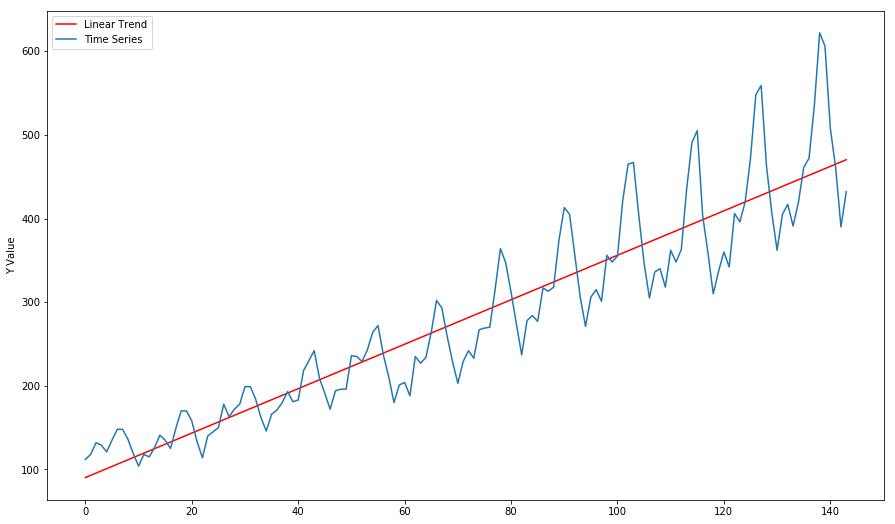

In [2]:
air = pd.read_csv('data/international-airline-passengers.csv', header=0, index_col=0, parse_dates=[0])
target = air.reset_index()['n_pass_thousands']


X = [i for i in range(0, len(air))]
X = np.reshape(X, (len(X), 1))
y = air['n_pass_thousands'].values
#model = LinearRegression()
#model.fit(X, y)
# calculate trend
#trend = model.predict(X)
# plot trend



from statsmodels import regression
def linreg(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    fig = plt.figure(1, figsize=(15, 9))
    ax = fig.add_subplot(111)
    ax.plot(X2, Y_hat, 'r', label="Linear Trend")
    ax.plot(y, label='Time Series')
    ax.legend()


    #X2 = np.linspace(X.min(), X.max(), 100)
    #Y_hat = X2 * b + a
    #plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    #plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    #plt.xlabel('X Value')

    plt.ylabel('Y Value')
    return model.summary()

summary = linreg(X, y)

Sometimes a Linear trend doesn't show the picture.  The trend could be going down, up, and flat all in one viewable period.

### Quadratic Trend

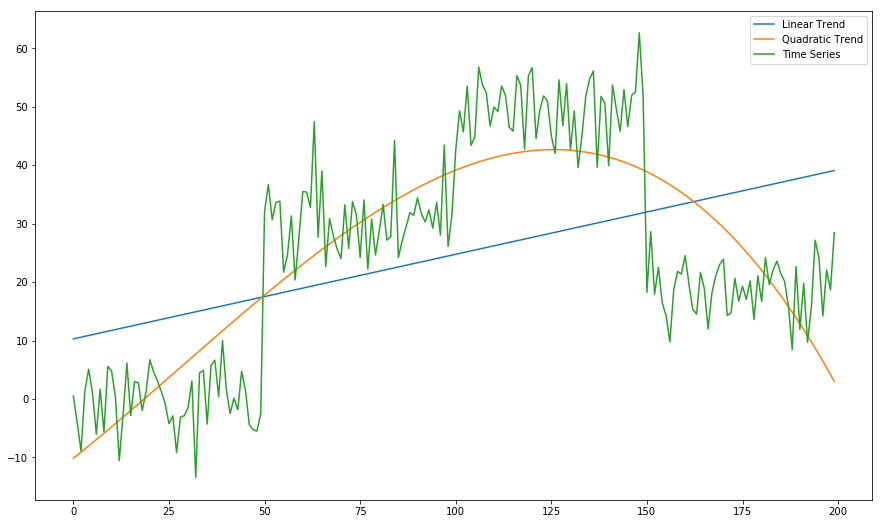

In [3]:
#make a trend changing series
y = [5*np.random.normal() for j in range(50)] + [30 + 5 * np.random.normal() for j in range(50)] +  [50 + 5 * np.random.normal() for j in range(50)] +  [20 + 5 * np.random.normal() for j in range(50)]
X = [x for x in range(len(y))]
X = np.reshape(X, (len(X), 1))

model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)

#degree = 2
# experimenting with other degrees for best fit is an option
model = make_pipeline(PolynomialFeatures(3), Ridge())
model.fit(X, y)
quadratic = model.predict(X)

fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
ax.plot(trend, label="Linear Trend")
ax.plot(quadratic, label="Quadratic Trend")
ax.plot(X, y, label='Time Series')
ax.legend()


Here you can see the data isn't always trending up even though the Linear regression indicated a rising trend through out the entire window.  Adding some polynomial regression shows a clearer picture on how the data is trending.

## Removing trend from a time series

Statsmodel comes with a detrending function that can take out a trend with 3 different orders:
* Linear
* Quadratic
* Constant

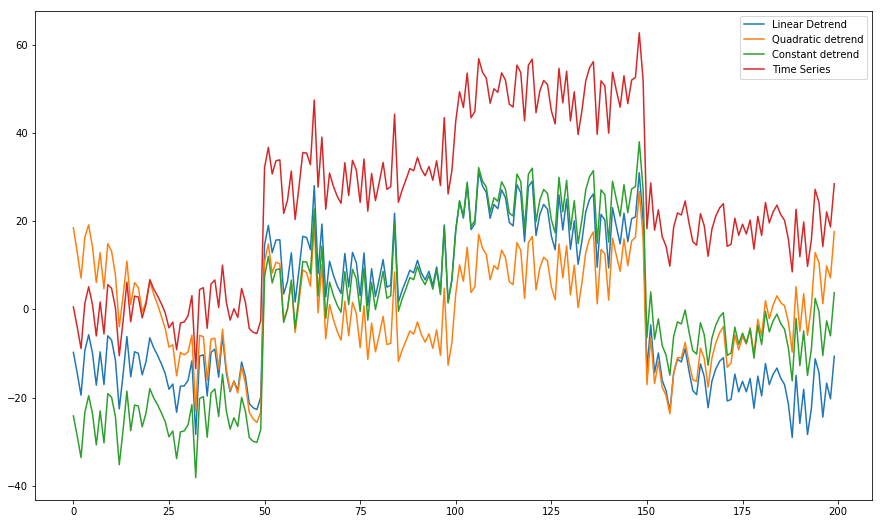

In [4]:
y = np.array(y)
y = np.reshape(y, (len(y), 1))

constant = smt.detrend(y, order=0)

linear = smt.detrend(y, order=1)

quadratic = smt.detrend(y, order=2)

fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
ax.plot(linear, label="Linear Detrend")
ax.plot(quadratic, label="Quadratic detrend")
ax.plot(constant, label='Constant detrend')
ax.plot(X, y, label='Time Series')


ax.legend()

# Trend Estimation

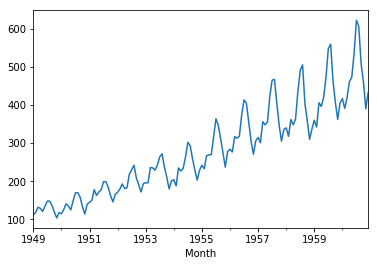

In [14]:
#time series used
df = pd.read_csv('data/international-airline-passengers.csv', header=0, index_col=0, parse_dates=[0])['n_pass_thousands']
df.plot()


## Moving Average Filtering

Moving average filtering is a linear model that isn't great for trend estimation but can provide a baseline to use to judge other models.  If there is a large window size without extreme outliers, it exposes a long-term trend.  It's not robust to outliers and abrupt changes, particularly for smaller window sizes.

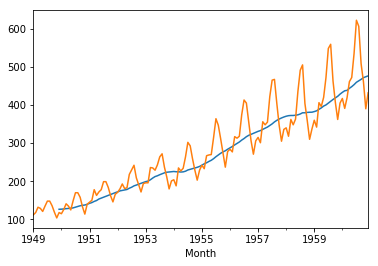

In [18]:
window = 12 #the larger the window, the more robust to outliers it will be
average_signal = df.rolling(window).mean()
average_signal.plot()
df.plot()

## Median Filtering

Median filter is a nonlinear model that is very robust to noise.  The trend signal is most likely not to smooth.  Large median windows could cause the median not to change.

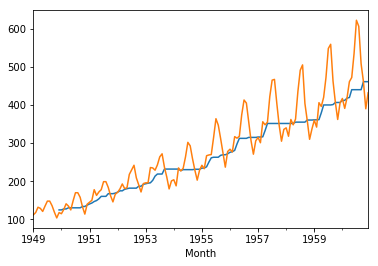

In [22]:
window = 12 
median_signal = df.rolling(window).median()
median_signal.plot()
df.plot()

## EWMA

Exponentially weighted moving average is a linear model that provides different weights to values in the window.  Weights are better distributed so could provide a better estimate.  This model is not robust to outliers and abrupt changes.  Very flexible about terms of weights and puts more emphasis on the spatial window in the signal.

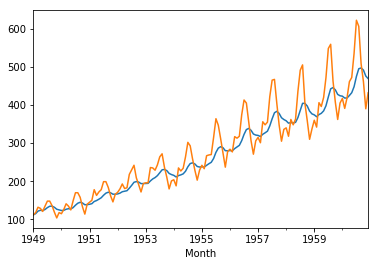

In [24]:
window = 12
df.ewm(span=window).mean().plot() #very simple example, many more options
df.plot()

## Bandpass Filtering

It filters based on frequency of the response of the series.  It reduces the effect of low range (long term) and very high frequency(short-term, volatility) and exposes a trend.  

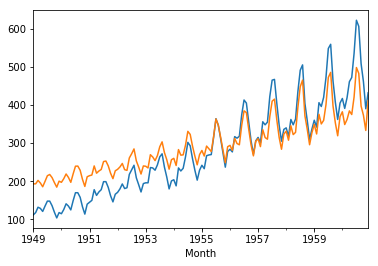

In [52]:
df = pd.read_csv('data/international-airline-passengers.csv', header=0, index_col=0, parse_dates=[0])

from scipy import signal

filter_order = 4              #need to add notes
low_cutoff_frequency = 0.001  #need to add notes
high_cutoff_frequency = 0.15  #need to add notes

b, a = signal.butter(filter_order, [low_cutoff_frequency, high_cutoff_frequency], btype='bandpass')

#plot bandpass
new_df = df
bandpass_filtered = signal.filtfilt(b, a, new_df['n_pass_thousands'])
new_df['filtered'] = new_df['n_pass_thousands'] - bandpass_filtered

new_df['n_pass_thousands'].plot()
new_df['filtered'].plot()

## Hodrick-Prescott Filter

This filter decomposes the time-series into a trend and cyclical component.  A linear model that resembles bandpass filter and works best when noise is normally distributed.

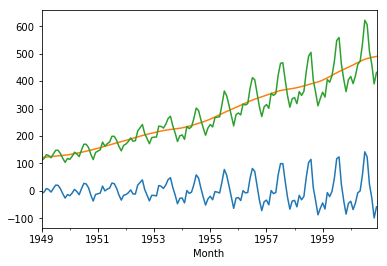

In [56]:
lamb = 1000

cycle, trend = sm.tsa.filters.hpfilter(df['n_pass_thousands'], lamb=lamb)

cycle.plot()
trend.plot()
df['n_pass_thousands'].plot()

## l_1 Trend Filtering

A nonlinear model that is generally very smooth.  Yields good results when series is exponentially distributed but can be computationally expensive.  Changes in trend could be used as outlier detection.

In [57]:
#No python example